# Modeling exercise

In [197]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [198]:
import pandas as pd
import numpy as np
import plotly_express as px
import ipywidgets as widgets

In [199]:
slope, intercept = 2.5, 6

In [200]:
x_1, x_2 = 0.2, 0.6
on_line = [[x, x*slope + intercept,'on_line'] for x in np.linspace(-1,2,100)]

above_line = [[x_1, x_1*slope + intercept + 2, 'Above'], 
              [x_2, x_2*slope + intercept + 2, 'Above']] 

below_line = [[x_1, x_1*slope + intercept - 2, 'Below'], 
              [x_2, x_2*slope + intercept - 2, 'Below']] 

In [201]:
columns = ['x','y','label']
data = pd.DataFrame(on_line + above_line + below_line, columns = columns)

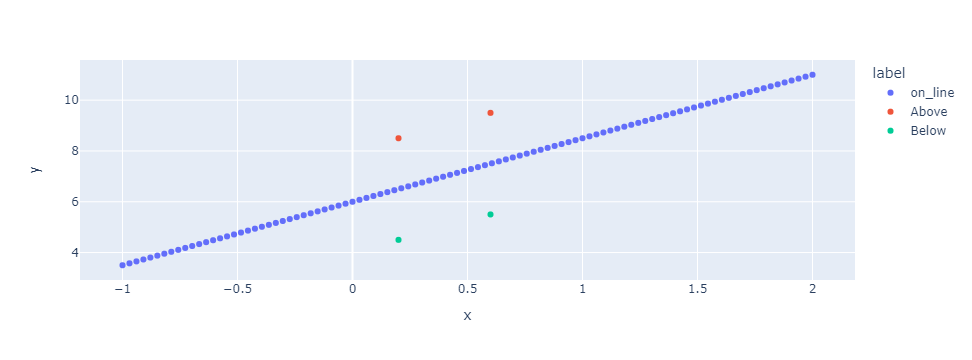

In [202]:
px.scatter(data, x='x', y='y', color = 'label')

## Fitting and Overfiting 

The goal of the following exercise is to observe overfitting causes:
* Overfitting due to insuffient data
* Overfitting due to overly complex model


For each below dataset:
* Create data of size N with noise level of magnitude NL. 
* Split it to training and testing data
* Choose a complex model of your choice: [KNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), [SVM with RBF kernel](https://scikit-learn.org/stable/modules/svm.html) with different `gamma` values or [Random forest classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) with differnt number of `min_samples_split`. 
* Train on the train test for different hyper parameter values. compute:
  * Classification accuracy on the training set (TRE)
  * Classification accuracy on the testing set (TESTE)
  * The difference beteen the two above (E_DIFF)
* Save N, NL, TRE, TESTE, E_DIFF and the regularization param (K, gamma or min_samples_split)

Repeat for N in range 50 to 10000 and NL in range 0 to 0.5. Create a proper dataframe from the results and analyze:
1. For a given noise level of your chioce, How does the train, test and difference error changes with increasing data sizes? 
1. For a given noise level of your chioce, How does the train, test and difference error changes with increasing model complexity? 
1. Select the best model param to fit the data (The one minimizing the test error) and for it, observe the number of data points needed for optimal test results in different noise levels.

## Fitting and Overfiting - answer

datasets to create:
 N=   5, 10, 50, 100, 1000, 10000
 NL=  0, 0.1, 0.2, 0.3, 0.4

### importing libraries

In [203]:
#Importing required libraries
from sklearn.datasets import make_moons, make_circles
from src.modeling_util import *
from sklearn import svm
from sklearn.model_selection import *
#from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import statistics
import ipywidgets as widgets
from scipy.stats import gmean

### Datasets creation and modeling

In [204]:
#run fully with ds creation and modeling or just retrive data from file (only analysis)
#default is False
run_ds_and_models = False
file_2_bu = "rdata_df_apr_17.csv"
file_retrieve_from = "rdata_df_apr_15.csv"

#diff variables to loop on:
C_range =  [0.001, 0.01, 0.1, 1, 10, 100, 1000] 
regulation_method = 'l2'
Gamma_range = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 1000] #added 1000
svm_kernel = 'rbf' 
k_folds = 10  #cross validation kfold 
classifiers = ['logistic', 'svm']
n_samples = [5, 10, 50, 100, 1000, 10000]
noise_lvl = [0, 0.1, 0.2, 0.3, 0.4, 0.5] 
data_types = ['circles', 'moons']
#constants
#train_test_por = 0.2
#rndm_seed = 42
#loop util vars
iter_count = 0
rdata_lst = []

In [205]:
##############################################################
##### main loop - running thru all options and collecting data
##############################################################
if run_ds_and_models:
    for n in n_samples:
        for nl in noise_lvl:
            for data_type in data_types:
                df = creat_dataset(n_smpl_size=n, noise_lvl=nl, type=data_type)
                #using all data for train and val #un-comment below to split
                #train, test = train_test_split(df, test_size=train_test_por, random_state=rndm_seed)
                print(f'Cross validation for {data_type} dataset with {n} samples and noise level {nl}')
                if n < k_folds:           #is num of samples smaller than k_fold use n
                    kf = KFold(n_splits=n)
                else:
                    kf = KFold(n_splits=k_folds)           #no shuffling 
                #kf = StratifiedKFold(n_splits=k) #no shuffling 
                acc_score = []         #to keep a list of all cross val scores
                for clf_type in classifiers:
                    #flow for svm model
                    if clf_type == 'svm':
                        #print(f'Going to train: {clf_type}')
                        for Gamma in Gamma_range:
                            #print(f'gamma: {Gamma}')
                            svm_clf = svm.SVC(kernel=svm_kernel, gamma=Gamma)
                            #using all data for train and val #un-comment below to split
                            #X = train.iloc[:,:-1] #without label
                            #y = train.iloc[:,-1]  #only label
                            X = df.iloc[:,:-1] #without label
                            y = df.iloc[:,-1]  #only label
                            cv_results = cross_validate(svm_clf, X, y, cv = kf, return_train_score=True)
                            #obtain train scores
                            TRE = sum(cv_results['train_score'])/k_folds
                            TRE_STD = statistics.pstdev(cv_results['train_score'])
                            TRE_VAR = statistics.pvariance(cv_results['train_score'])
                            #obtain test scores
                            TESTE = sum(cv_results['test_score'])/k_folds
                            TESTE_STD = statistics.pstdev(cv_results['test_score'])
                            TESTE_VAR = statistics.pvariance(cv_results['test_score'])
                            E_DIFF = TRE - TESTE
                            #debug print - TODO comment
                            #print(f'{TRE:.2f}, {TRE_STD:.2f}, {TESTE:.2f}, {TESTE_STD:.2f}, {E_DIFF:.2f}')
                            #collect the data 
                            iter_dic = {}
                            iter_dic.update({"n": n, "noise_lvl": nl, "data_type": data_type, "model": clf_type,
                                             "TRE": TRE, "TRE_STD": TRE_STD, "TESTE": TESTE,
                                             "TESTE_STD": TESTE_STD, "E_DIFF": E_DIFF, "model_param": Gamma})
                                            #model_param is gamma
                            rdata_lst.append(iter_dic)
                    #flow for logistic regression
                    if clf_type == 'logistic':
                        #print(f'Going to train {clf_type}')
                        for C in C_range:
                            log_reg = LogisticRegression(penalty=regulation_method, C=C)
                            #using all data for train and val #un-comment below to split
                            #X = train.iloc[:,:-1] #without label
                            #y = train.iloc[:,-1]  #only label
                            X = df.iloc[:,:-1] #without label
                            y = df.iloc[:,-1]  #only label
                            cv_results = cross_validate(log_reg, X, y, cv = kf, return_train_score=True)
                            #obtain train scores
                            TRE = sum(cv_results['train_score'])/k_folds
                            TRE_STD = statistics.stdev(cv_results['train_score'])
                            TRE_VAR = statistics.variance(cv_results['train_score'])
                            #obtain test scores
                            TESTE = sum(cv_results['test_score'])/k_folds
                            TESTE_STD = statistics.stdev(cv_results['test_score'])
                            TESTE_VAR = statistics.variance(cv_results['test_score'])
                            E_DIFF = TRE - TESTE
                            #debug print - TODO comment
                            #print(f'{TRE:.2f}, {TRE_STD:.2f}, {TESTE:.2f}, {TESTE_STD:.2f}, {E_DIFF:.2f}')
                            #collect the data 
                            iter_dic = {}
                            iter_dic.update({"n": n, "noise_lvl": nl, "data_type": data_type, "model": clf_type,
                                             "TRE": TRE, "TRE_STD": TRE_STD, "TESTE": TESTE, "TRE_VAR": TRE_VAR,
                                             "TESTE_STD": TESTE_STD, "TESTE_VAR": TESTE_VAR, "E_DIFF": E_DIFF, "model_param": C})
                                            #model_param is C
                            rdata_lst.append(iter_dic)

    #end of -> for n in n_samples:
    #results list of dict into a dataframe
    rdata_df = pd.DataFrame.from_dict(rdata_lst)
#end of -> if run_ds_and_models:

### Data backup or retrieve data from file

In [206]:
#data created so backup or data not created and retrive data from file to work on
if run_ds_and_models:
    #backup results data to csv
    rdata_df.to_csv(file_2_bu)
else:
    #retreive backup results from csv
    rdata_df = pd.read_csv(file_retrieve_from) 
    #notes on bu files - april_6 does NOT have nl=0.5, kfold=10; april_9 has nl=0.5, kfold=10;
    # april_14: kfold=5, gamma_range added 1000; april_15: kfold=10; april_17 moved to statistics.stdev, variance
    # note - the data creation is done with random_state=None so we see slightly different results on diff runs
    

In [207]:
rdata_df.sample(4)

,Unnamed: 0,n,noise_lvl,data_type,model,TRE,TRE_STD,TESTE,TRE_VAR,TESTE_STD,TESTE_VAR,E_DIFF,model_param
784,784,100,0.3,moons,svm,0.804444,0.011331,0.780,NaN,0.107703,NaN,0.024444,0.050
931,931,1000,0.1,moons,svm,0.999889,0.000333,1.000,NaN,0.000000,NaN,-0.000111,1.000
944,944,1000,0.2,circles,svm,0.503556,0.002424,0.468,NaN,0.021817,NaN,0.035556,0.005
138,138,5,0.3,moons,svm,0.400000,0.100000,0.100,NaN,0.400000,NaN,0.300000,0.500


In [208]:
#dimenstions of the results
rdata_df.shape

(1296, 13)

### Defining the Widgets

In [209]:
#defining the widgets
import ipywidgets as widgets
n_wid = widgets.Dropdown(options=n_samples, value=n_samples[-1], description='n:',disabled=False,)
model_wid = widgets.Dropdown(options=classifiers, value=classifiers[-1], description='model:',disabled=False,)
nl_wid = widgets.Dropdown(options=noise_lvl, value=noise_lvl[-2], description='noise:',disabled=False,)
data_wid = widgets.Dropdown(options=data_types, value=data_types[-1], description='data type:',disabled=False,)
gamma_wid = widgets.Dropdown(options=Gamma_range, value=Gamma_range[3], description='gamma values:',disabled=False,)
log_C_wid = widgets.Dropdown(options=C_range, value=C_range[2], description='Logistic C values:',disabled=False,)

### Answer to Q1

In [210]:
# Q1 - For SVM only, For dataset of size 10k and for each dataset, What are the best model params? How stable is it?

In [211]:
############# remove when data has it in the loops (build-in)
rdata_df['TRE_VAR'] = rdata_df['TRE_STD'].apply(lambda x: x*x)
rdata_df['TESTE_VAR'] = rdata_df['TESTE_STD'].apply(lambda x: x*x)

In [212]:
@widgets.interact
#plotting accuracy kfold mean by hyperparameter (combined diff noise levels)    
def show_acc_vs_gamma(data_type=data_wid):
    # only for svm and 10k n sample size
    cmodel = "svm"
    cn = 10000
    fig, gamma_max, acc_max, gamma_max_std = plot_acc_vs_gamma(rdata_df, cmodel, cn, data_type)
    fig.show()
    print(f'for {data_type} data: Maximum Accuracy achieved by gamma= {gamma_max} with: acc= {acc_max:.2f} std= {gamma_max_std:.3f}')
    print()
    display(df_acc_vs_gamma(rdata_df, cmodel, cn, data_type))
    return

interactive(children=(Dropdown(description='data type:', index=1, options=('circles', 'moons'), value='moons')…

In [213]:
# For circles data-type - we can see that the 'best' model parameter (high prediction accuracy; gamma for svm/rbf) has 
# gamma=0.1 - 1 (depending on diff data creation runs) - so, with regards to 'close' vs 'far' gamma influence  or complexity
# vs the other gamma values - it is quite in the middle range of gamma values) - the terminology to use -> low bias. 
# We also see it is stable, with low variance (compared to other models) - In general what we desire when choosing hyperparameter 
# (low bias and low variance) - more in Q2 answer.
# what we see also in different runs of the data creation and modeling - around gamma 0.05 untill gamma 10 we get an increase and 
# reach good accuracy of test accuracy (TESTE) but then afterwards on gamma 50 and 1000 (on more complex fits) we see 
# degradation of the prediction accuracy.
#
# For moons data-type - we see a similar picture with gamma=5 or gamma=10 for other runs -> low bias and low variance
# we also see the same behavior pattern - accuracy starts to increase in around gamma 0.05 untill gamma 0.5 where we reach good 
# accuracy of TESTE. this good accuracy is seen throught until gamma 10 but then afterwards on gamma 50 and 1000 we see back 
# a degradation of the prediction accuracy (overfitting - more in answer to Q5)
#
# note - used data april 14, april 15

### Answer to Q2

In [214]:
#Q2 - For SVM only, For dataset of size 10k and for each dataset, What is the most stable model and model params? 
#     How good is it in comparison to other models? Explain using bias and variance terminoligy.

In [215]:
@widgets.interact
#plotting accuracy kfold std (and mean) by hyperparameter (combined diff noise levels)       
def show_std_vs_gamma(data_type=data_wid):
    # only for svm and 10k n sample size
    cmodel = "svm"
    cn = 10000
    fig, gamma_min_std, std_min, acc_std_min = plot_std_vs_gamma(rdata_df, cmodel, cn, data_type)
    fig.show()
    print(f'for {data_type} data: Minimum Accuracy STD achieved by gamma= {gamma_min_std} with: std= {std_min:.3f} acc= {acc_std_min:.2f} ')
    print()
    return

interactive(children=(Dropdown(description='data type:', index=1, options=('circles', 'moons'), value='moons')…

In [216]:
# For circles data-type - we can see that the most stable (lowest std) parameter (gamma for svm/rbf) has gamma=0.001 
# (aka very 'far' influence or low complexity vs the other gamma values) the terminology we use: it has low variance. 
# on the other hand the accuracy of prediction is not good (actually the worst) relativley to the other gamma values - aka 
# it has high bias. The goal of any supervised machine learning algorithm is to achieve low bias and low variance. So, when 
# choosing the best model parameter we need to balance out bias and variance (Bias-Variance Trade-Off). Here (in circles data-type, 
# 10k samples, svm/rbf model) using gamma=0.001 will NOT be a good value to choose - since the bias is very high (will not accuratilty
# predict). We will choose a slightly less stable model (a bit higher variance) but will achieve high accuracy (low bias) 
# - like gamma=1 or 10 for example
#
# For moons data-type - we see a different picture. we see that the most stable gamma has gamma=0.5 (aka mid range 'far'-'close'
# influence or mid complexity) - has low variance. Nevertheless here, we see it has low bias - quite good accuracy. here we do not 
# encounter this Bias-Variance Trade-Off dilema as we have both low variance and low bias. I assume this might have to do with the
# specific c value we chose (arbitrary) for this expirement (I assume we need different c values to explore it further)
#
#sources: 
# https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html
# https://machinelearningmastery.com/gentle-introduction-to-the-bias-variance-trade-off-in-machine-learning/

### Answer to Q3

In [217]:
# Q3 - Does regularization help for linear models? consider different datasets sizes.

In [218]:
@widgets.interact
#plotting accuracy kfold mean and std by hyperparameter for diff n data sizes (combined diff noise levels) 
def show_acc_vs_clog(data_type=data_wid):
    cmodel = 'logistic'
    fig = plot_acc_vs_clog(rdata_df, cmodel, data_type)
    fig2 = plot_acc_std_vs_clog(rdata_df, cmodel, data_type)
    fig.show()
    fig2.show()
    return

interactive(children=(Dropdown(description='data type:', index=1, options=('circles', 'moons'), value='moons')…

In [219]:
# We see two different behaviors with regards to impact of l2 regularization in logistic regression.
# In 'moons' dataset we do see regularization helps in logistic regression - we see an increase of accuracy with an increase of 
# penalty (C). We see it more dramaticly on lower data sizes (except n=5 which looks like an anomaly): we see smaller data sizes need 
# larger penalty (c) values to "get closer" to best-accuracy achieved in its data size. In the large (1K, 10K) data sizes we see 
# very minor improvement. On stability, accuracy STD we do see some (very) minor improvement in the lower dataset sizes but no 
# change in the large (1K, 10K) - their accuracy STD stay constant (and very small/close to zero) across penalty (c) values.
#
# In circles dataset we do NOT see in general that regularization helps in logistic regression. We see very minor changes of 
# accuracy across penalty (c) values. Accuracy stays pretty constant across penatly (c) values where the different accuracies are
# determined by the n-sample size (for combined of noise-levels) - larger, more accurate. In general logistic regression was not
# able to get accurate on circles data-type (not able to reach acc=0.5). We even see minor degradation 
# (like in n=50, n=100). Larger n sample sizes (1k, 10k) the accuracy stays constant throughout different penalty values. 
# On stability we also do NOT see an improvement, actualy a minor degradation on lower data sizes (10, 50, 100) and on higher 
# data sizes (1K, 10K) it is quite constant throughout different penalty values.
# I assume the data pattern is too complex for this linear model (logistic regression) - so even different penatly (c) values
# do not make a difference.

### Answer to Q4

In [220]:
# Q4 - For a given noise level of your chioce, How does the train, test and difference error changes with increasing data sizes?

In [221]:
@widgets.interact
#plotting train, val accuracy and error difference (per data_type, noise_lvl, model param) vs n sample size    
def show_CV_train_test_error_vs_n( model=model_wid, gamma=gamma_wid, c=log_C_wid, nl=nl_wid, data_type=data_wid):
    if model == 'svm':
        fig2 = plot_CV_DIFF_vs_n2(rdata_df, gamma, nl, data_type, model)
        fig2.show()
    elif model == 'logistic':
        fig2 = plot_CV_DIFF_vs_n2(rdata_df, c, nl, data_type, model)
        fig2.show()
    return

interactive(children=(Dropdown(description='model:', index=1, options=('logistic', 'svm'), value='svm'), Dropd…

In [222]:
# SVM :
# I chose to look first on gamma=1 which should be in the optimum range for circles (see answer to Q1). I looked across different
# noise levels - the pattern is similar (although the values of train, test accuracies and error difference differ as well as
# at which n data size (x in the graph) it happens - the pattern in general is similar).
# We see in lower n data size (n=10) that train accuracy (TRE) is high vs low test accuracy causing error difference (E_DIFF) 
# to be the highest (overfit in too small dataset). When increasing n sample size: we see a decrease for train accuracy
# and an increase on test accuracy (TESTE) until it reaches the TRE (at large data size like 10K sometimes 1K). 
# This causes the error difference (E_DIFF) to decrease (in general) as data size increase (except n=5 which looks like an
# anomaly) until it is close to zero (when TESTE reaches close to TRE).
# This pattern (TESTE increases and E_DIFF decreases with n) is also seen when using gamma=1000 (most complex)
# with some differences in the accuracy values and rates (slopes) and TRE staying constant - but the overall pattern 
# is similar (TESTE increases and E_DIFF decreases with n). 
# We can see that TESTE increase rate is 'slower' - aka only in very large datasets ~10k in circles it gets closer to TRE and 
# with noisy dataset it even cannot get close to TRE and E_DIFF stays significant.
# We see the same pattern in 'moons' data type (with overall better prediction accuracies)

# Logistic regression
# in general we see the same pattern as SVM - test accuracy (TESTE) increases and error difference (E_DIFF) decreases with n. 
# Of course there are changes of the accuracy values and the rates (slopes; at which n it happens) comparing within logistc 
# regression different penalties, data-types and noise levels and also with comparing to SVM - 
# but the bottomline - this pattern is similar --> test accuracy (TESTE) increases and error diff (E_DIFF) decreases with n. So,
# as we seen in many examples in class when we have larger datasets we are able to get better fit and predictions. On lower
# n-sample size (n~10, sometimes 50 depending on noise and/or data-type) we see the overfit phenomenon (higher E_DIFF).
#
#(note - at very low n sample size  n=5 - the data changes on every dataset creation as 1 point difference will cause 0.2 change)

### Answer to Q5

In [223]:
#Q5 - For a given noise level of your chioce, How does the train, test and difference error changes with increasing model complexity?

In [224]:
#plotting train, val accuracy and error difference (per data_type, noise_lvl, n) vs hyperparam values
@widgets.interact
def show_CV_train_test_error(n=n_wid, nl=nl_wid, data_type=data_wid, model=model_wid):
    fig = plot_CV_train_test_error(rdata_df, n, nl, data_type, model)
    fig.show()
    fig2 = plot_CV_DIFF_E(rdata_df, n, nl, data_type, model)
    fig2.show()
    return

interactive(children=(Dropdown(description='n:', index=5, options=(5, 10, 50, 100, 1000, 10000), value=10000),…

In [225]:
# for SVM - from the graphs we can clearly observe the overfitting phenomenon with overly complex model:
# looked as an example - at n=10k, noise=0.3 and data_type=moons 
# what we see as a general pattern is: increasing complexity (or gamma increasing) increases both train (TRE) and test (TESTE)
# accuracy - until it reaches a point (a certain gamma value) that test accuracy (TESTE) starts degrading (and error 
# difference E_DIFF starts increasing). The terminology to use is: overfitting - when the model is too close aligned to 
# the training data points - hence TRE continues to increase - while, on the unfamiliar data points (validation/test) its 
# predication accuracy degrades - hence TESTE starts to decrease (in this example around gamma >= 20). For an optimal model
# we will choose a lower parmeter (less complex model) not to 'reach' overfitting (in this case: gamma between 0.5-10).
# This is observed on both data_types (moons and circles). 
# We observe overfitting is higher (higher E_DIFF values) and starts 'earlier' (in lower gammas values) in higher noise levels 
# as well as overfitting is higher on smaller datasets (lower n).

### Answer to Q6

In [226]:
#Q6 - Are the noise level effect the number of datapoints needed to reach minimal test results?

In [227]:
@widgets.interact
#plotting Accuracy and Error Difference for diff Noise levels (per data_type, model, model param) vs n sample size     
def show_CV_model_error1(data_type=data_wid, model=model_wid, gamma=gamma_wid, c=log_C_wid):
    fig = plot_CV_DIFF_vs_n6(rdata_df, data_type, model, gamma, c)
    #print(fig)
    fig.show()
    return

interactive(children=(Dropdown(description='data type:', index=1, options=('circles', 'moons'), value='moons')…

In [228]:
@widgets.interact
#plotting Accuracy/best-Accuracy-achieved Proportion (per data_type, model, model param) for diff Noise levels vs n sample size    
def show_CV_model_error3(data_type=data_wid, model=model_wid, gamma=gamma_wid, c=log_C_wid):
    fig = plot_CV_DIFF_vs_prop(rdata_df, data_type, model, gamma, c)
    #print(fig)
    fig.show()
    return

interactive(children=(Dropdown(description='data type:', index=1, options=('circles', 'moons'), value='moons')…

In [229]:
# Observation from the  graphs (focusing on high noise levels: 0.4, 0.5 vs low noise levels: 0, 0.1) is that the noisier the 
# dataset the best-accuracy is lower. also in most cases the best-accuracy is reached on the larger n-sample size.
# intuition would have lead to the conclusion that the noisier dataset will reach "good" (or "minimal") accuracy
# on larger n-sample size compared to the "cleaner" dataset. But - in general the data is inconclusive. In many cases (different
# data_types, diff models) I cannot say that on higher noise levels you need larger n sample size to reach better results. 
# The observations I see are that on noiser data the model reaches lesser accurancy, but the rate of reaching it (with regrads 
# to increasing n sample size) is similar to the cleaner data.

## Moons dataset

In [ ]:
from sklearn.datasets import make_moons

In [ ]:
points, label = make_moons(n_samples=1000, noise=0.25)
moons_df = pd.DataFrame(points, columns=['x','y'])
moons_df['label'] = label
moons_df.label = moons_df.label.map({0:'A', 1:'B'})
moons_df.head()

In [ ]:
px.scatter(moons_df, x='x', y='y', color = 'label')

In [ ]:
@widgets.interact
def plot_noisy_moons(noise_level = widgets.FloatSlider(value=0, min=0, max=0.5, step=0.05)):
    points, label = make_moons(n_samples=1000, noise=noise_level)
    moons_df = pd.DataFrame(points, columns=['x','y'])
    moons_df['label'] = label
    moons_df.label = moons_df.label.map({0:'A', 1:'B'})
    return px.scatter(moons_df, x='x', y='y', color = 'label')

## Circles Dataset

In [81]:
from sklearn.datasets import make_circles

In [ ]:
def make_circles_dataframe(n_samples, noise_level):
    points, label = make_circles(n_samples=n_samples, noise=noise_level)
    circles_df = pd.DataFrame(points, columns=['x','y'])
    circles_df['label'] = label
    circles_df.label = circles_df.label.map({0:'A', 1:'B'})
    return circles_df

In [ ]:
circles_df = make_circles_dataframe(n_samples=500, noise_level=0)
circles_df.head()

In [ ]:
px.scatter(circles_df, x='x', y='y', color = 'label')

In [ ]:
@widgets.interact
def plot_noisy_circles(noise_level = widgets.FloatSlider(value=0, min=0, max=0.5, step=0.05)):
    df = make_circles_dataframe(1000, noise_level)
    return px.scatter(df, x='x', y='y', color = 'label')